# Framing the Problem

One of the major reason why the Canadian banking system continues to thrive despite constant changes in financial innovations and technological integrations are due to the impact of OSFI's (Office of the Superintendent of Financial Institutions) stringent rules and regulations.

As a result, all Canadian banks and financial institutions undergo audits periodically in order to satisfy the OSFI's financial regulations and requirements.

Furthermore, financial institutions also perform their own internal audits and third party audits to ensure quality control for liquidity management and securitization respectively.

However, current audits are solely based on each Auditor's own merits and common sense knowledge/opinions given the nature of banking.

For example, an Auditor would check off each criteria in order to satisfy a Bank's own policy for a given Client under a certain product. However, sometimes an exception is made when a Client does not meet all the criteria given circumstances in the real world, but as long as these risks are mitigated while still satisfying the Bank's policy, then the Auditor should continue to check off all the criteria.

An example like this is why audit results can vary from a case by case scenario. If the exception that was made above satisfies the Bank's policy 100% of the time, Auditors would still disagree 20% of the time. The reason for this is that Humans can make bias errors and opinion errors from our decision making process, while on the other hand, computers do not make the same bias errors and opinion errors, but instead make different errors which is not comparable to Human errors (ie. understanding jokes, sarcasm, etc).

<br>
**Business Solution:**
<br>
<br>
To solve this issue, I have created an internal "Audit Rating System" that learns and understands a Bank's decision making process for a certain product of a department in order to avoid errors that an Auditor can potentially make 20% of the time.

I will perform a Sentiment Analysis with Random Forest Classifier on an entire department's deal notes for a particular product.

<u>Note</u>: Deal notes are the key factor here since this is where exceptions for mitigating risks are explained by the bank, and reviewed by the Auditor.

I will also identify and display key words that arise in an audit under any variations (ie. 1 word, 2 words, 1-2 words, etc). This feature is useful to see how well the department is performing, and if the performance is meeting the Bank's expectations.

<br>
**Benefits:**
<br>
- Develop a Bank's own audit rating system using Machine Learning
- Improve the quality of financial products for securitization
- Collectively understand an entire department's decision making approach
- Anticipate internal/external audits
- Ensure risk mitigations are explained in detail in accordance to a Bank's expectations

<br>
**Robustness:**
<br>
<br>
To ensure the model performs well using new data and does not over-fit the training data, I will implement the following measures:
- Split the data between 80% training data, and leave the remaining 20% of data as testing data. The testing data will not be touched until after the model construction is complete
- Implement the Random Forest Model which runs the Decision Tree Model repeatedly (this ensures that the model learns the entire department's decision making approach accurately)
- Apply cross validation after running the Random Forest Model on the training data to find the best outcome (this further ensures the model learns the entire department's decision making approach, as well as each individual banker's unique decision making approach)

<u>Note</u>: Although I will be using real world data from a Bank, however, I will not showcase any relevant information from the actual dataset for privacy protection. Any information shown here will not violate the privacy of the Bank.

<br>
**Assumptions:**
<br>
<br>
- I have taken data from a department when a new policy was implemented, and assuming 500 dataset is sufficient to capture all banker's decision making approach
- There are more Clients declined than approved, however, since the length of deal notes for approvals are significantly longer than length of deal notes for declines, then we're assuming that the longer length in deal notes for approvals will balance out the lesser number of Clients approved

<br>
**Future:**
<br>
<br>
This model is the first step for implementing an internal "Audit Rating System". In the future, I will perform additional models to other datasets for creating an auto approval system and other innovative ways to enhance a Financial Institution's capabilities using Machine Learning and Deep Learning.

# Data Overview

In [1]:
import pandas as pd
csv = ("audit_rating_banking.csv")
df = pd.read_csv(csv, encoding='latin1') # solves enocding issue when importing csv
df.head(0)

,Underwriter,Deal Number,Decision,Deal Notes


Here we see that the dataset that we used includes the Banker's name, Deal number, Decision and Deal Notes columns.
<br><u>Note</u> that I did not show any data for privacy protection.

In [2]:
df1 = df.copy()
df1["Deal Notes"] = df1["Deal Notes"].apply(lambda x : x.rsplit(maxsplit=len(x.split())-4)[0]) # sets the character limit to 4 words
df1.loc[2:4,'Decision':'Deal Notes']

,Decision,Deal Notes
2,Denied,Unfortunately I will have
3,Denied,Were going to pass
4,Approved,Credit: main applicant has


I wrote a function showing select data:
- We see that under "Decision", there are two attributes: Approve and Denied
- We also see the "Deal Notes" of each Banker's decision making process (only the first 4 words were used for privacy protection, and I also omitted the names of each individual Banker)

# Splitting data in Training Set and Testing Set

First we need to clean our data to ensure no missing values in our data

In [3]:
print("Before dropping missing data: {}".format(len(df)))
df = df.dropna(subset=["Deal Notes"])
print("After dropping missing data: {}".format(len(df)))

Before dropping missing data: 511
After dropping missing data: 511


Next we will split the data into 80% training data and 20% testing data to avoid over-fitting.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(df, df["Decision"]): 
    strat_train = df.reindex(train_index)
    strat_test = df.reindex(test_index)
print("Number of Training Data: " + str(len(strat_train)),
      "\nNumber of Testing Data: " + str(len(strat_test)))

Number of Training Data: 408 
Number of Testing Data: 103


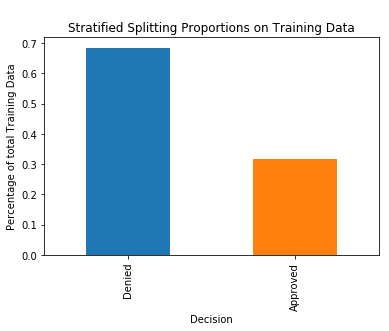

Denied      0.683824
Approved    0.316176
Name: Decision, dtype: float64


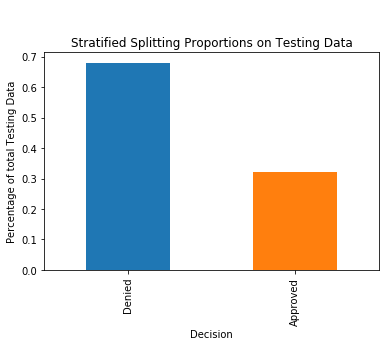

Denied      0.679612
Approved    0.320388
Name: Decision, dtype: float64


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

strat_train["Decision"].value_counts()/len(strat_train)
a = strat_train["Decision"].value_counts()/len(strat_train)
ax = a.plot(kind='bar', title='\nStratified Splitting Proportions on Training Data')
ax.set_xlabel('Decision')
ax.set_ylabel('Percentage of total Training Data')
plt.show()
print(strat_train["Decision"].value_counts()/len(strat_train))


strat_test["Decision"].value_counts()/len(strat_test)
b = strat_test["Decision"].value_counts()/len(strat_test)
bx = b.plot(kind='bar', title='\n\nStratified Splitting Proportions on Testing Data')
bx.set_xlabel('Decision')
bx.set_ylabel('Percentage of total Testing Data')
plt.show()
print(strat_test["Decision"].value_counts()/len(strat_test))

We have successfully split the data into 80% training data and 20% testing data. As shown in the bar graphs and split percentages above, both training set and testing set were split evenly to ensure data were not just split right down the middle.

# Modeling

### Set Target Variable

In [6]:
X_train = strat_train["Deal Notes"] # X_train to include Deal Notes only in training set
X_train_targetSentiment = strat_train["Decision"] # X_train_targetSentiment to include Decision only in training set

X_test = strat_test["Deal Notes"] # X_test to include Deal Notes only in test set
X_test_targetSentiment = strat_test["Decision"] # X_test_targetSentiment to include Decision only in test set

Data are now assigned and ready for modeling.

### Extract Features

We will use Sci-Learn's **CountVectorizer** to performs the following:
- Text preprocessing:
    - Tokenization (breaking the sentence into words)
    - Remove Stopwords (filtering "the", "are", etc)
- Occurrence counting (builds a dictionary of features from integer indices to word occurrence)
- Feature Vector (converts the dictionary of a collection of text documents to a feature vector)


Since longer documents will have higher average count values on words that carry very little meaning, this will overshadow shorter documents that have lower average counts with same frequencies, as a result, we will use also use **TfidfTransformer** to reduce this redundancy:
- Term Frequencies (**Tf**) divides number of occurrence of each word in a document by total number of words in the document
- Term Frequencies times Inverse Document Frequency (**Tfidf**) downscale weights for words that occur in many documents (assigns less value to unimportant stop words ie. "the", "are", etc)


Lastly, we see that in our training set, there are 408 sample size with 3971 distinct words.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) # transform documents to feature vector (fit and transform)
print("Number of samples and number of features using CountVectorizer: " + str(X_train_counts.shape))

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False) # disable inverse document frequency reweighting
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print("\nNumber of samples and number of features using Tfidf: " + str(X_train_tfidf.shape))

Number of samples and number of features using CountVectorizer: (408, 3844)

Number of samples and number of features using Tfidf: (408, 3844)


### Feature Pipeline

For efficiency, we will create a pipeline to fit_transform the training data as well as transform the testing data.

In [8]:
from sklearn.pipeline import Pipeline
feat_pipe = Pipeline([('count_vect', CountVectorizer()), ('tfidf', TfidfTransformer())])
X_train = feat_pipe.fit_transform(X_train) 
X_test = feat_pipe.transform(X_test)

### Making Predictions with Different Classifiers

With our features engineered and ready to be used for making predictions, we will perform the following:
- Run the features through a variety of classifiers using our training data only 
- Then use each of these trained classifiers to test the accuracy for making predictions on our testing data

**Multinominal Naive Bayes Classifier**

In [9]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB

multiNB_clf = MultinomialNB().fit(X_train, X_train_targetSentiment)
predicted_multiNB_clf = multiNB_clf.predict(X_test)
np.mean(predicted_multiNB_clf == X_test_targetSentiment)

0.9223300970873787

**Logistic Regression Classifier**

In [10]:
from sklearn.linear_model import LogisticRegression

logReg_clf = LogisticRegression().fit(X_train, X_train_targetSentiment)
predicted_logReg_clf = logReg_clf.predict(X_test)
np.mean(predicted_logReg_clf == X_test_targetSentiment)

0.970873786407767

**Support Vector Machine Classifier**

In [11]:
from sklearn.svm import LinearSVC

linearSVC_clf = LinearSVC().fit(X_train, X_train_targetSentiment)
predicted_linearSVC = linearSVC_clf.predict(X_test)
np.mean(predicted_linearSVC == X_test_targetSentiment)

0.9805825242718447

**Decision Tree Classifier**

In [12]:
from sklearn.tree import DecisionTreeClassifier

decisionTree_clf = DecisionTreeClassifier().fit(X_train, X_train_targetSentiment)
predicted_decisionTree_clf = decisionTree_clf.predict(X_test)
np.mean(predicted_decisionTree_clf == X_test_targetSentiment)

0.8932038834951457

**Random Forest Classifier**

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # hides deprecation warning
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier().fit(X_train, X_train_targetSentiment)
predicted_forest_clf = forest_clf.predict(X_test)
np.mean(predicted_forest_clf == X_test_targetSentiment)

0.9902912621359223

Looks like all the models performed very well (>89%), and we will use the **Random Forest Classifier** since it has the higest accuracy level at **99.03%**.
<br>Now we will fine tune the Random Forest Classifier to avoid any potential over-fitting.

### Fine-tune the Random Forest Classifier with Cross Validation

Here we will run a **GridSearchCV** function which will optimize all the hyper-parameters on a grid of possible values. This is done by taking all available combinations of hyper-parameters and perform cross validations by splitting the training data into 10 folds, and cross validate each fold against one another for 10 times. These cross validated results are then averaged to produce a generalized score for the fitness of our Random Forest Model and its optimal hyper-parameters.


We also indicated 3 **n_estimators** x 4 **max_features** x 1 **bootstrap** x 10 **folds** = 120 trained random forest in our GridSearchCV below.

<u>Note</u> that each **n_estimator** hyper-parameter value represents the number of trees trained in the Random Forest, and we set our hyper-parameter as following:
<br>(**150 trees** x 4 max_features x 10 folds) + (**200 trees** x 4 max_features x 10 folds) + (**250 trees** x 4 max_features x 10 folds) = 24,000 individual trees trained in our Random Forest Model.

In addition, we also optimized the number of CPU core utilization for efficient processing.

One key factor for running 24,000 individual trees is to avoid Humans from replicating keywords used to pass the audit, and  have the model learn the entire department's decision making approach instead. Therefore, even if Humans try to replicate certain keywords, the model will be robust enough to filter through those keywords based on its learning.

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [150,200,250], 'max_features': [2, 4, 'log2', 'auto'], 'bootstrap': [False]}
]
grid_search = GridSearchCV(forest_clf, param_grid, cv=10, verbose=2, n_jobs=-1)
grid_search.fit(X_train, X_train_targetSentiment)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   32.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [150, 200, 250], 'max_features': [2, 4, 'log2', 'auto'], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [15]:
final_model = grid_search.best_estimator_
final_model

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now that the fine-tuning is complete, we then select the best estimator from the cross validation results and prepare the final model for testing.

### Testing the Final Model

I have taken any arbitrary text to see if our model is able to predict the quality of Deal Notes to be reviewed by an Auditor.

<u>Note</u> that the actual text used is not in our training data or testing data, and the text is actually 300 words long.

In [16]:
new_text = ['Client is a receptionist at XYZ Inc...']

docs_prepared = feat_pipe.transform(new_text)
X_train_targetSentiment[final_model.predict(docs_prepared)]

Approved    NaN
Name: Decision, dtype: object

In [17]:
predictedFinal = final_model.predict(X_test)
np.mean(predictedFinal == X_test_targetSentiment)

0.970873786407767

**Results:**
- After testing any arbitrary text that is not in our training data or testing data, we see that our final model is performing correctly with Approved result
- We also see that the final model has an accuracy level of **97.09%**, which is slightly lower than our pre-fine-tuned model at 99.03% accuracy level
- The 1.94% difference shows that the fine-tuning was able to capture some over-fitting and ensure that the model is able to learn the entire department's decision making approach, as well as each individual banker's unique decision making approach

# Detailed Analysis

In [18]:
for performance_analysis in (grid_search.best_score_, 
                             grid_search.best_estimator_, 
                             grid_search.best_params_):
        print(performance_analysis)

0.9803921568627451
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 250}


In our performance analysis, we see the following:
- Best Mean Score: 98.04& which is very close to our accuracy level of 97.09%
- Best Estimator: shown above
- Best Parameter: shows "250 n_estimators", "auto max_features", and "bootstrap false"

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(X_test_targetSentiment, predictedFinal))
print('Accuracy: {}'. format(accuracy_score(X_test_targetSentiment, predictedFinal)))

             precision    recall  f1-score   support

   Approved       1.00      0.91      0.95        33
     Denied       0.96      1.00      0.98        70

avg / total       0.97      0.97      0.97       103

Accuracy: 0.970873786407767


Below is the summary of the classification report:
- Precision: determines how many objects selected were correct
- Recall: tells you how many of the objects that should have been selected were actually selected
- F1 score measures the weights of recall and precision (1 means precision and recall are equally important, 0 otherwise)
- Support is the number of occurrences of each class (X_test_targetSentiment and X_test)

The results in this analysis shows the strong performance of our model for understanding how the department decides if Clients are approved or declined. This is also supported by the strong Precision, Recall, and F1-score. Furthermore, we also tested our model above using arbitrary text  with great results. 

Also, our assumption above is also validated by our results given that the the longer length in deal notes for approvals will balance out the lesser number of Clients approved.

Overall, the Precision, Recall, F1-score, and test results along with our validated assumption confirms the effectiveness of this model.

In [20]:
from sklearn import metrics
metrics.confusion_matrix(X_test_targetSentiment, predictedFinal)

array([[30,  3],
       [ 0, 70]], dtype=int64)

From the confusion matrix above, we see that our model shows no confusion between approval and declines based on the entire department's decision making approach. The numbers in the matrix is from the total support number which is the number of occurrences of each class in our testing data.

Although there is a 2.91% chance (3/(30+70+3)) that our model may confuse an approval with a denial, however this value is very marginal and the model satisfies our goal of creating an "Audit Rating System" to avoid the 20% errors that Auditors can potentially make based on bias errors and opinion errors.

Therefore, we conclude that our model is able to learn and understand a Bank's decision making process for a certain product of a department in order to avoid errors that an Auditor can potentially make 20% of the time.

# Text Visualization with Eli5

Now that we have completed our model, I would like to take a step further by identifying the keywords that were used in our matrix for determining our Audit Rating System.

In order to display the keywords, we will first perform the following:
- Reset the target variables
- Extract the features again but using a **TfidfVectorizer** hybrid (this is important to work with out Eli5 package)
- Perform our Random Forest Classifier once more
- Fine-tune our Random Forest Classifier with cross validation once more
- Apply the final model with **Eli5** to display the key words for visualization

### Set Target Variable

In [21]:
X_train = strat_train["Deal Notes"] # X_train to include Deal Notes only in training set
X_train_targetSentiment = strat_train["Decision"] # X_train_targetSentiment to include Decision only in training set

X_test = strat_test["Deal Notes"] # X_test to include Deal Notes only in test set
X_test_targetSentiment = strat_test["Decision"] # X_test_targetSentiment to include Decision only in test set

### Extract Features

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1)) # display key words that arise in an audit under any variations
tfidf_vec.fit(X_train.values.tolist())
X_train = tfidf_vec.transform(X_train.values.tolist())
X_test = tfidf_vec.transform(X_test.values.tolist())

### Perform Random Forest Classifier

In [23]:
forest_clf = RandomForestClassifier().fit(X_train, X_train_targetSentiment)

### Fine-tune the Random Forest Classifier with Cross Validation

In [24]:
param_grid = [
    {'n_estimators': [150,200,250], 'max_features': [2, 4, 'log2', 'auto'], 'bootstrap': [False]}
]
grid_search = GridSearchCV(forest_clf, param_grid, cv=10, verbose=2, n_jobs=-1)
grid_search.fit(X_train, X_train_targetSentiment)
final_model = grid_search.best_estimator_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   34.8s finished


### Displaying Text Visualization

In [25]:
import eli5
eli5.show_weights(final_model, vec=tfidf_vec, top=3)

Using the Eli5 package, we can show all the key words and their respective weights that impacts the model's ability to learn the department's decision making approach. 

This is usefully in evaluating how well the department is performing, and if the performance is meeting the Bank's expectations for audits.

Also, the model is robust enough from our cross validation fine-tuning that, even if Humans try to replicate certain keywords, the model will not rely solely on those keywords, but instead on the entirety of its learning.

<u>Note</u>: 
- Under the extract features section where we implemented "TfidfVectorizer", we can adjust the "ngram_range" parameter to show any variation of keywords and sentences (ie. 1 word, 2 words, 1-2 words, 3-10 words sentence, 6 words sentence, etc)
- We can also adjust the "top" parameter in "eli5.show_weights" and assign it to "top = 3614" to view all the keywords and the weights of the keywords in the entire data set


For privacy protection, I only displayed keywords in 1-gram while showing only the first 3 results.

# Answering the Questions

From the analysis above in the classification report, we see that the model is able to perform as an "Internal Audit System" for understanding the department's decision making approach on Client approvals and denials. With this knowledge, we use our model to avoid the 20% errors that Auditors can potentially make based on bias errors and opinion errors.

Also, we solidified the model by taking various steps to avoid biasness and over-fitting. This was done by splitting the data between training data and testing data, performing Random Forest Classifier, and implementing cross validation on the Random Forest Classifier to ensure the robustness of our model, such that, even if Humans try to replicate certain keywords, the model will not rely solely on those keywords, but instead on the entirety of its learning.

As result, we tested the model on an arbitrary text data and showed strong performance in predicting results using the department's decision making approach.

Furthermore, we used Eli5 to determine keywords and key sentences along with their respective weights that impacts the model's ability to learn the department's decision making approach. This is especially usefully in evaluating how well the department is performing, and if the performance is meeting the Bank's expectations for audits.

Lastly, based on our modeling, the robustness of our model, our test results, and our text visualization,  we conclude that our model is able to learn and understand a Bank's decision making process for a certain product of a department in order to avoid errors that an Auditor can potentially make 20% of the time.